
# Bacterial Colony Segmentation using Computer Vision Techniques in Python"



## Autores:


- Cardona Duque, David
- Marín Roa, Rubén Santiago
- Martin Acosta, David Esteban
- Sanchez Gonzalez, Jose Miguel
- Agudelo Gonzalez, Gabriel

## Objetivos


### Objetivo general 


Emplear técnicas de visión artificial para procesar de manera eficaz imágenes de un cumulo de bacterias y predecir una mascara para las mismas.


### Objetivos especificos

-	Procesar las imágenes del dataset de tal manera que podamos facilitar el proceso de segmentación, intentando hacer que las características de las células resalten mas a la hora de extraer bordes.

- Usar las imagenes procesadas para generar un treshold mediante el metodo de otsu y producir una segmentacion por umbralizacion

-	Usar las imágenes preprocesadas para alimentar una red neuronal la cual se encargará de realizar el proceso de segmentación prediciendo la máscara de las bacterias

## Justificación 


Los cultivos de bacterias son imágenes con las que es interesante trabajar puesto que la manera en la que estas se agrupan crea el reto de intentar extraer aquellas partes de un cultivo en las que se encuentran bacterias y en las que no.
La idea de este proyecto es intentar crear una mascara que ayude a diferenciar las bacterias ya sean aisladas o en un cumulo de un cultivo dado. Para esto usamos un dataset con 1200 imágenes las cuales contienen tanto imágenes con bacterias aisladas como agrupadas en un lugar del cultivo, y usando herramientas de visión artificial buscamos preparar las imágenes de la mejor manera posible para poder obtener las características que hacen que podamos identificar la ubicación de las bacterias en el cultivo.

### Descripcion del dataset

El dataset que se analiza en el proyecto, es tomado de la colección Broad Bioimage Benchmark Collection (BBBC), colección que ofrece imágenes microscópicas de libre uso, específicamente se usó el image set: BBBC05 "Synthetic cells". Dataset que tiene su principal aplicación en la segmentación de objetos celulares, las imágenes son imágenes HCS simuladas que se generaron con plataforma de simulación SIMCEP para imágenes de población de células fluorescentes, estas imágenes se simularon para un recuento de celdas determinado con una probabilidad de agrupación del 25 % y una variación del ruido CCD de 0,0001. 

Cada imagen tiene 696 x 520 píxeles en formato TIF de 8 bits, se usaron 1200 imágenes, ya que en este dataset solo 1200 imágenes tienen una máscara asociada, se hizo así para poder contrastar la predicción de la red.

Las imágenes también cuentan con unos metadatos o nomenclatura, que nos dan información con respecto a la cantidad de células que hay en la imagen y cuanto células tiene un desenfoque aplicado, también se nos suministra más información, pero estos son los datos más principales.

Por ejemplo: 
    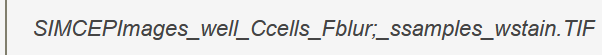
    



## Metodología 



Para llevar a cabo el proyecto teniendo en cuenta el objetivo general, se planea seguir de manera sistemática algunos algoritmos de visión artificial. En primera medida, se implementan operaciones de pre procesamiento de la imagen para generar condiciones ideales en la etapa de segmentacion. Posteriormente, se procede a implementar una red neuronal y por aparte la umbralizacion utilizando el metodo de otsu como tecnicas de segmentacion debido a que las imagenes de celulas tienen un distintivo fondo negro y en una escala de grises se pueden diferenciar facilmente del mismo. Asi, se generar posteriormente un analisis de resultados entre las mascaras reales de cada imagen y las predichas.


## Exploración dataset 


De el dataset completo se seleccionaron solo las imagenes que tenian una mascara asociada, esto a razon de poder contrastar las predicciones de nuestra red neuronal contra la mascara verdadera de cada imagen, por esto se anexa en el repositorio la carpeta con 1200 imagenes y otra con las 1200 mascaras correspondientes, tenga en cuenta que las mascaras tienen el mismo nombre de archivo que su imagen correspondiente.


### Librerias

In [4]:
#Se importan las librerias necesarias para el proyecto
import os
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.color import rgb2gray
from skimage import io
import cv2
import pandas as pd
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

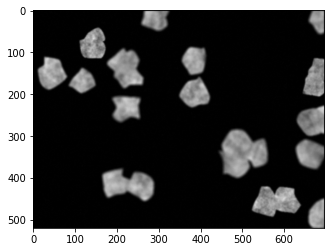

In [3]:
#se lee la primera imagen del proyecto y se muestra
imageo = cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenes/SIMCEPImages_A06_C23_F1_s11_w2.TIF")

plt.imshow(imageo)

### Lectura de datos

In [4]:
# Obtiene una lista de archivos en cada carpeta

img_list = os.listdir(os.path.abspath(os.getcwd())+'/content/imagenes')
mask_list = os.listdir(os.path.abspath(os.getcwd())+'/content/mascaras')


df_images = pd.DataFrame(img_list, columns=['image_id'])

df_images = df_images[df_images['image_id'] != '.htaccess']





# ===============================================================
# Agrega una columna mostrando cuantas celulas hay en cada imagen
# ===============================================================

def get_num_cells(x):
    a = x.split('_')
    b = a[2] 
    num_cells = int(b[1:])
    
    return num_cells

df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ==============================================================
# Agrega una columna indicando si se tiene mascara asociada o no
# ==============================================================

#las mascaras y las imagenes tienen el mismo nombre

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



# ===========================================================
# Agrega una columna mostrando cuanto blur tiene cada imagen
# ===========================================================

def get_blur_amt(x):
    a = x.split('_')
    b = a[3] 
    blur_amt = int(b[1:])
    
    return blur_amt

df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)

df_images['mask_id'] = df_images['image_id']

df_images.head

<bound method NDFrame.head of                                  image_id  num_cells has_mask  blur_amt  \
0       SIMCEPImages_A01_C1_F1_s01_w1.TIF          1      yes         1   
1       SIMCEPImages_A01_C1_F1_s01_w2.TIF          1      yes         1   
2       SIMCEPImages_A01_C1_F1_s02_w1.TIF          1      yes         1   
3       SIMCEPImages_A01_C1_F1_s02_w2.TIF          1      yes         1   
4       SIMCEPImages_A01_C1_F1_s03_w1.TIF          1      yes         1   
...                                   ...        ...      ...       ...   
1195  SIMCEPImages_A24_C100_F1_s23_w2.TIF        100      yes         1   
1196  SIMCEPImages_A24_C100_F1_s24_w1.TIF        100      yes         1   
1197  SIMCEPImages_A24_C100_F1_s24_w2.TIF        100      yes         1   
1198  SIMCEPImages_A24_C100_F1_s25_w1.TIF        100      yes         1   
1199  SIMCEPImages_A24_C100_F1_s25_w2.TIF        100      yes         1   

                                  mask_id  
0       SIMCEPImages_A01_

### Exploracion

Tomando encuenta la descripcion del dataset nos interesa categorizar las imagenes segun su cantidad de celulas simuladas. Por eso importamos la carpeta con las imagenes,y usamos la función listdir de la libreria os y generamos una lista con los nombres de los archivos contenidos en la carpeta, y como sabemos que cada imagen cuenta con una nomenclatura que nos indica la cantidad de celulas simuladas sera facil categorizarlas

In [5]:
img_list = os.listdir(os.path.abspath(os.getcwd())+'/content/imagenes')
lista_ccells=[]
for numero in range(0,1200):
    x=img_list[numero].split("_")
    lista_ccells.append(x[2])
# =======================================================================
# Se busca encontrar cuanta categorias del tipo C1,C2,C3 tiene el dataset
# =======================================================================

print("Cantidad de categorias en el dataset: "+ str(len(set(lista_ccells)))) 

# =======================================================================
# Se busca encontrar cuales son las categorias
# =======================================================================

print("Cuales son las categorias en el dataset: "+ str(list(set(lista_ccells))))

Cantidad de categorias en el dataset: 24
Cuales son las categorias en el dataset: ['C10', 'C27', 'C61', 'C23', 'C78', 'C53', 'C44', 'C83', 'C35', 'C31', 'C1', 'C18', 'C70', 'C96', 'C5', 'C48', 'C66', 'C87', 'C40', 'C91', 'C100', 'C74', 'C14', 'C57']


#### Histograma

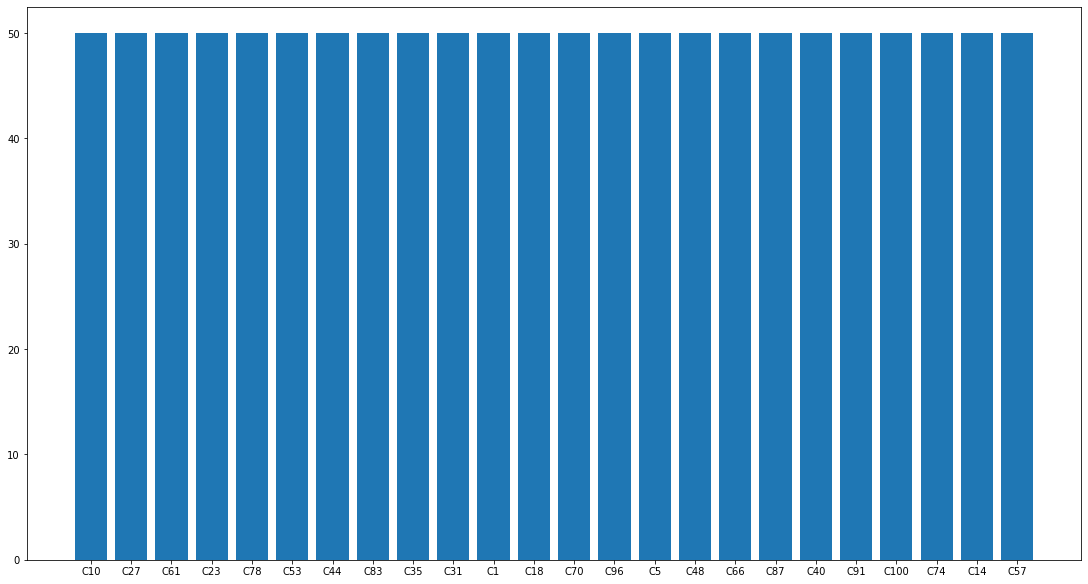

In [6]:
#Se crea un histograma por cada categoria
Ccell_categoria=[]
for numero in range(0,24):
    Ccell_categoria.append(lista_ccells.count(list(set(lista_ccells))[numero]))
fig, ax = plt.subplots(figsize=(15, 8), layout='constrained')
ax.bar((list(set(lista_ccells))), Ccell_categoria);

Como podemos ver por el histograma, por cada categoria que hay, cada una tiene la misma cantidad de imagenes.

Ahora procedemos a visualizar algunas imagenes del dataset,para esto usaremos la libreria matplotlb.

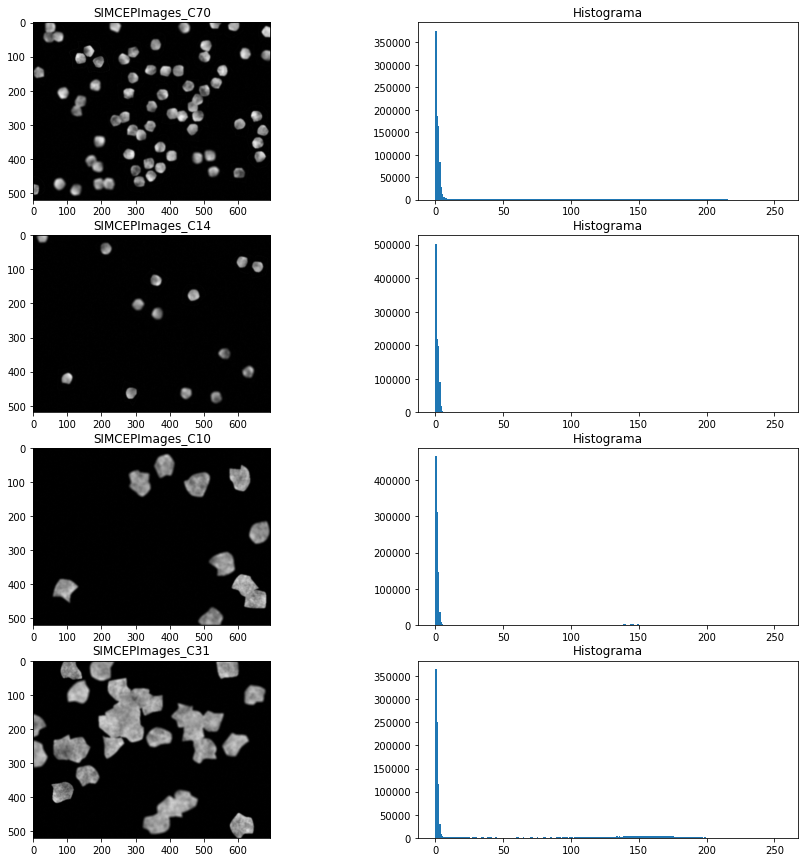

In [7]:

#Se leen las imagenes a utilizar para la exploracion
img_cnv =cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenes/SIMCEPImages_A17_C70_F1_s09_w1.TIF")
img_dme =cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenes/SIMCEPImages_A04_C14_F1_s05_w1.TIF")
img_drusen =cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenes/SIMCEPImages_A03_C10_F1_s07_w2.TIF")
img_normal =cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenes/SIMCEPImages_A08_C31_F1_s09_w2.TIF")

#Se genera un arreglo para imprimir las imágenes, 4x2, 4 imágenes y 4 histogramas asociados.
fig, arreglo_plots = plt.subplots(4,2, figsize=(15, 15))
#Título del cuadro en la posición (0,0)
arreglo_plots[0,0].set_title('SIMCEPImages_C70')
#Imprimir la imagen 1 en la posición (0.0) del arreglo
arreglo_plots[0,0].imshow(img_cnv)
#Título del cuadro en la posición (0,1)
arreglo_plots[0,1].set_title('Histograma')
#Imprimir el histograma en la posición (0,1)
_ = arreglo_plots[0,1].hist(img_cnv.ravel(), bins=256, range=(0.0, 255.0))    

#Análogamente para los demás casos, como se observa varía la posición asociada en el subplot
arreglo_plots[1,0].set_title('SIMCEPImages_C14')
arreglo_plots[1,0].imshow(img_dme)
arreglo_plots[1,1].set_title('Histograma')
_ = arreglo_plots[1,1].hist(img_dme.ravel(), bins=256, range=(0,255))

arreglo_plots[2,0].set_title('SIMCEPImages_C10')
arreglo_plots[2,0].imshow(img_drusen)
arreglo_plots[2,1].set_title('Histograma')
_ = arreglo_plots[2,1].hist(img_drusen.ravel(), bins=256, range=(0.0, 255.0))

arreglo_plots[3,0].set_title('SIMCEPImages_C31')
arreglo_plots[3,0].imshow(img_normal)
arreglo_plots[3,1].set_title('Histograma')
_ = arreglo_plots[3,1].hist(img_normal.ravel(), bins=256, range=(0.0, 255.0))

Como podemos ver, en general en los histogramas la frecuencia que mas predomina son tonos oscuros, y se llega a visualizar unos pequeños picos a lo largo del histograma, pero que no son significativos. Esto nos lleva a pensar que el modelo de color que deberiamos usar es de escala de grises.

## Pre-procesamiento



### Aplicacion del pre procesamiento a una imagen

(-0.5, 695.5, 519.5, -0.5)

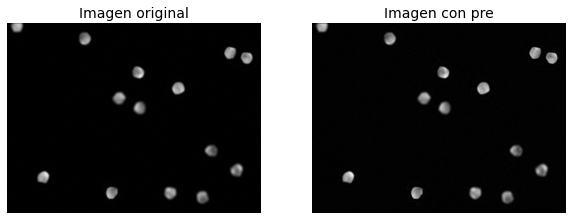

In [5]:
imagen = cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenes/SIMCEPImages_A04_C14_F1_s05_w1.TIF")
imagen_list = []

for d in range(3):
    temp = signal.convolve2d(imagen[:,:,d] , np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),  boundary='symm',mode='same')
    imagen_list.append(temp)

imagen_filt = np.stack(imagen_list, axis=2)
imagen_filt[imagen_filt > 255] = 255
imagen_filt[imagen_filt < 0] = 0

# se crea el lienzo para los subplot
plt.figure(figsize=(10,10))
plt.axis('Off')
    
# imagen de prueba
plt.subplot(1,2,1)
plt.imshow(imagen)
plt.title('Imagen original', fontsize=14)
plt.axis('off')


# imagen con pre procesamiento
plt.subplot(1,2,2)
plt.imshow(imagen_filt, cmap='gray')
plt.title('Imagen con pre', fontsize=14)
plt.axis('off')
    
    

### Funcion y aplicacion a todo el data set de pre procesamiento

Lo que se busca en un principio en el pre-procesamiento es corregir el efecto blur (desenfoque) que tienen algunas imagenes que están en el dataset, para esto
se hizo función para calcular la convolución entre una imagen y un kernel, en este caso en imagenes en blanco y negro (2D, 1 channel), en escencia una matriz con valores entre 0 y 255, se hace la convolución con el kernel(nucleo) [[0,-1,0],[-1,5,-1],[0,-1,0]] el cual nos sirve para enfocar los pixeles centrales, resaltarlos, y crear un tipo de efecto de enfoque, con el cual se trata de mitigar el efecto blur con el que cuentan las imagenes. Al revisar la imagen resultante al aplicar el output se puede notar cómo se logra mitigar levemente el efecto blur. Pero en general recuperar la resolución o enfoque en una imagen es algo bastante complicado, dado que no se puede recuperar la información perdida al aplicar el efecto blur facilmente aplicando filtros, se espera que con la aplicación de este filtro la red neuronal pueda mejorar la calidad de la mascara predicha.   



In [ ]:
# se obtiene la ruta de las imagenes

input_images_path = os.path.abspath(os.getcwd())+"/content/imagenes"
files_names = os.listdir(input_images_path)

# Se elige a donde iran las imagenes procesada y si no existe la carpeta se cree
output_images_path =  os.path.abspath(os.getcwd())+"/content/imagenesPre"

if not os.path.exists(output_images_path):
    os.makedirs(output_images_path)
    print("Directorio creado: ", output_images_path)

count = 0
for file_name in files_names:

    image_path = input_images_path + "/" + file_name
    imagen = cv2.imread(image_path)
    if imagen is None:
        continue

#=================================
# Aqui inicia el pre procesamiento
#=================================
    %matplotlib notebook
    plt.ion()

    imagen_list = []
    for d in range(3):
        temp = signal.convolve2d(imagen[:,:,d] , np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),  boundary='symm',mode='same')
        imagen_list.append(temp)

    imagen_filt = np.stack(imagen_list, axis=2)
    imagen_filt[imagen_filt > 255] = 255
    imagen_filt[imagen_filt < 0] = 0

#===================================
# Aqui finaliza el pre procesamiento
#===================================
    
    cv2.imwrite(output_images_path + "/"+file_name, imagen_filt)
    count += 1







Directorio creado:  C:\Users\david\Documents\Universidad\Semestre 6\Vision artificial\Trabajo/content/imagenesPre


## Creación máscaras


### Umbralizacion

El proceso de umbralizacion es un metodo que debe separar los objetos del fondo mediante encontrar un "umbral" con el cual filtrar la imagen y sus pixeles, el metodo utilizado en esta ocasion para encontrar el umbral de manera automatica fue el mediante el metodo de otsu, el cual retorna una sola intensidad para el umbral que separa los pixeles en 2 clases, fondo y primer plano. 

In [17]:
import skimage
blurred_image = cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenesPre/SIMCEPImages_A06_C23_F1_s11_w2.TIF")
blurred_image = skimage.color.rgb2gray(blurred_image)
real_mask=cv2.imread(os.path.abspath(os.getcwd())+"/content/mascaras/SIMCEPImages_A06_C23_F1_s11_w2.TIF")

In [23]:
# se encuentra el umbral de manera automatica mediante el metodo de otsu
t = skimage.filters.threshold_otsu(blurred_image)
print("Se encontro el umbral automatico t = {}.".format(t))

# se crea la mascara mediante el umbral t encontrado con otsu
binary_mask = blurred_image > t

Found automatic threshold t = 0.29471507352941173.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


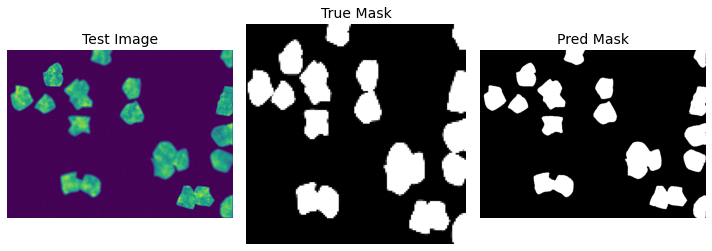

In [24]:
# se crea el lienzo para los subplot
plt.figure(figsize=(10,10))
plt.axis('Off')
IMG_HEIGHT = 128
IMG_WIDTH = 128


# Se crean los subplots con su imagen correspondiente
# == row 1 ==

# imagen de prueba
plt.subplot(3,3,1)
plt.imshow(blurred_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# mascara verdadera
plt.subplot(3,3,2)
real_mask = resize(real_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(real_mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# mascara predicha
plt.subplot(3,3,3)
plt.imshow(binary_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')




plt.tight_layout()
plt.show()

### Red neuronal

Usaremos una red neuronal basada en la arquitectura U-net, la cual entrenaremos con 1200 imagenes previamente procesadas. A continuacion crearemos un dataset nuevo con el pre procesamiento ya aplicado y procederemos a generar la red.

### Creacion del dataset nuevo con las imagenes pre procesadas

In [28]:
# Obtiene una lista de archivos en cada carpeta

img_list = os.listdir(os.path.abspath(os.getcwd())+'/content/imagenesPre')
mask_list = os.listdir(os.path.abspath(os.getcwd())+'/content/mascaras')


df_images = pd.DataFrame(img_list, columns=['image_id'])

df_images = df_images[df_images['image_id'] != '.htaccess']


# ===============================================================
# Agrega una columna mostrando cuantas celulas hay en cada imagen
# ===============================================================

def get_num_cells(x):
    a = x.split('_')
    b = a[2] 
    num_cells = int(b[1:])
    
    return num_cells

df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ==============================================================
# Agrega una columna indicando si se tiene mascara asociada o no
# ==============================================================

#las mascaras y las imagenes tienen el mismo nombre

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



# ===========================================================
# Agrega una columna mostrando cuanto blur tiene cada imagen
# ===========================================================

def get_blur_amt(x):
    a = x.split('_')
    b = a[3] 
    blur_amt = int(b[1:])
    
    return blur_amt

df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)

df_images['mask_id'] = df_images['image_id']

df_images.head

<bound method NDFrame.head of                                  image_id  num_cells has_mask  blur_amt  \
0       SIMCEPImages_A01_C1_F1_s01_w1.TIF          1      yes         1   
1       SIMCEPImages_A01_C1_F1_s01_w2.TIF          1      yes         1   
2       SIMCEPImages_A01_C1_F1_s02_w1.TIF          1      yes         1   
3       SIMCEPImages_A01_C1_F1_s02_w2.TIF          1      yes         1   
4       SIMCEPImages_A01_C1_F1_s03_w1.TIF          1      yes         1   
...                                   ...        ...      ...       ...   
1195  SIMCEPImages_A24_C100_F1_s23_w2.TIF        100      yes         1   
1196  SIMCEPImages_A24_C100_F1_s24_w1.TIF        100      yes         1   
1197  SIMCEPImages_A24_C100_F1_s24_w2.TIF        100      yes         1   
1198  SIMCEPImages_A24_C100_F1_s25_w1.TIF        100      yes         1   
1199  SIMCEPImages_A24_C100_F1_s25_w2.TIF        100      yes         1   

                                  mask_id  
0       SIMCEPImages_A01_

In [29]:
# se define el ancho, el alto y el canal de todas las imagene por defecto, ademas el numero de imagenes de prueba
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10


### Crear un set de prueba

Aqui crearemos un set de prueba conteniendo 10 imagenes. Keras creara un set de validacion de manera automatica en el entrenamiento de la red.



In [30]:
# se crea el set de prueba
df_test = df_images.sample(NUM_TEST_IMAGES, random_state=101)


df_test = df_test.reset_index(drop=True)

test_images_list = list(df_test['image_id'])


#Selecciona solo las filas que no hacen parte del set de prueba

df_images = df_images[~df_images['image_id'].isin(test_images_list)]

print(df_images.shape)
print(df_test.shape)

(1190, 5)
(10, 5)


###  Inspeccionar una imagen y su respectiva mascara




Aqui encotraremos:

    Cuales son las dimensiones
    la imagen es RGB o blanco y negro


Necesitaremos esta informacion para escribir el codigo que procesara las imagenes y las mascaras a un formato que el modelo requiere



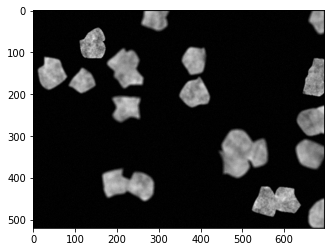

In [31]:
# se lee una imagen cualquiera para fines de obtener informacion relevante
image = cv2.imread(os.path.abspath(os.getcwd())+"/content/imagenesPre/SIMCEPImages_A06_C23_F1_s11_w2.TIF")

plt.imshow(image)



In [32]:

#se imprime el maximo pixel, el minimo y la forma de la matriz
print('Shape: ', image.shape)
print('Max pixel value: ', image.max())
print('Min pixel value: ', image.min())





Shape:  (520, 696, 3)
Max pixel value:  242
Min pixel value:  0


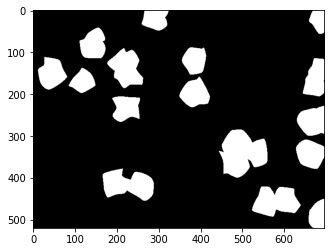

In [33]:

#se lee la mascara asociada de la imagen anterior
mask = cv2.imread(os.path.abspath(os.getcwd())+"/content/mascaras/SIMCEPImages_A06_C23_F1_s11_w2.TIF")

plt.imshow(mask, cmap='gray')



In [34]:
#se imprimen los mismos datos de la imagen anterior con objetivo de comparacion
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (520, 696, 3)
Max pixel value:  255
Min pixel value:  0


La imagen y su mascara asociada tienen las mismas dimensiones, vemos que la imagen es 2D. La mascara es 2D. La imagen tiene un rango de pixeles entre 0 a 255. La mascara tiene valores de pixeles  0 o 255. 0 si es negro y 255 si es blanco.

El modelo requiere un formato de input asi:

(num_samples, num_rows, num_columns, num_channels)

Por consiguiente, necesitaremos usar np.expand_dims para añadir un canal de dimension para la imagen y la mascara.

Ademas, el modelo espera un input de imagenes y mascaras que tengan los mismos tamaños, por esto cambiaremos sus tamaños a las mascaras y las imagenes a 128x128.



### Crear X_train, Y_train y X_test


In [35]:
# lista de las imagenes y sus mascaras.
image_id_list = list(df_images['image_id'])
mask_id_list = list(df_images['mask_id'])
test_id_list = list(df_test['image_id'])


#se definen las estructuras para el X_train, el Y_train y el X_test
X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)

In [36]:
# X_train


for i, image_id in enumerate(image_id_list):
    
    path_image = os.path.abspath(os.getcwd())+'/content/imagenesPre/' + image_id
    
    image = cv2.imread(path_image,cv2.IMREAD_GRAYSCALE)
    

    # se hacen los ajustes necesarios para que cumplan las condiciones del modelo
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    image = image.reshape(128,128)

    image = np.expand_dims(image, axis=-1)
    
    X_train[i] = image
    
X_train.shape

(1190, 128, 128, 1)

In [37]:
# Y_train


for i, mask_id in enumerate(mask_id_list):
    
    path_mask = os.path.abspath(os.getcwd())+'/content/mascaras/' + mask_id
    
    mask = cv2.imread(path_mask,cv2.IMREAD_GRAYSCALE)

    # se hacen los ajustes necesarios para que cumplan las condiciones del modelo

    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    mask = mask.reshape(128,128)


    mask = np.expand_dims(mask, axis=-1)
    
    Y_train[i] = mask

Y_train.shape

(1190, 128, 128, 1)

In [38]:
# X_test

for i, image_id in enumerate(test_id_list):
    
    path_image = os.path.abspath(os.getcwd())+'/content/imagenesPre/' + image_id
    
    image = cv2.imread(path_image,cv2.IMREAD_GRAYSCALE)
    
    # se hacen los ajustes necesarios para que cumplan las condiciones del modelo

    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = image.reshape(128,128)

    image = np.expand_dims(image, axis=-1)
    
    X_test[i] = image
    
X_test.shape

(10, 128, 128, 1)

### Definir la arquitectura del modelo


Usaremos la arquitectura U-Net. U-Net es una cnn que fue desarrollada para segmentacion de imagenes biomedicas. Fue diseñada para dar buenos resultados con un numero pequeño de imagenes de entrenamiento dismonibles. Ademas, fue diseñada para correr rapido.

Paper: U-Net: Convolutional Networks for Biomedical Image Segmentation
Olaf Ronneberger, Philipp Fischer, Thomas Brox

Las imagenes estan normalizadas dentro del modelo utilizando un lambda layer.





In [39]:
#librerias necesarias para la implementacion de la red neuronal
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [40]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

#se define la arquitectura del modelo con base a keras u-net
inputs = Input((IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

### Entrenar el modelo


Dejaremos que keras cree automaticamente un set de validacion del 10% durante el entrenamiento. No se especificara una metrica y se evaluara el resultado, en caso de malos resultados se podria especificar una.


In [41]:
#se define en donde se almacenara el modelo, el numero de toleracia a una no mejoria en el mismo, ademas de la manera en la cual
# el modelo genera su checkpoint

filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.0943
Epoch 00001: val_loss improved from inf to 0.05308, saving model to model.h5
67/67 [==============================] - 66s 980ms/step - loss: 0.0943 - val_loss: 0.0531
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0334
Epoch 00002: val_loss improved from 0.05308 to 0.04089, saving model to model.h5
67/67 [==============================] - 65s 970ms/step - loss: 0.0334 - val_loss: 0.0409
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0278
Epoch 00003: val_loss improved from 0.04089 to 0.03658, saving model to model.h5
67/67 [==============================] - 67s 998ms/step - loss: 0.0278 - val_loss: 0.0366
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.0250
Epoch 00004: val_loss improved from 0.03658 to 0.03196, saving model to model.h5
67/67 [==============================] - 66s 987ms/step - loss: 0.0250 - val_loss: 0.0320
Epoch 5/50
67/67 [==

Epoch 36/50
67/67 [==============================] - ETA: 0s - loss: 0.0096
Epoch 00036: val_loss did not improve from 0.01741
67/67 [==============================] - 67s 997ms/step - loss: 0.0096 - val_loss: 0.0176
Epoch 37/50
67/67 [==============================] - ETA: 0s - loss: 0.0094
Epoch 00037: val_loss did not improve from 0.01741
67/67 [==============================] - 67s 997ms/step - loss: 0.0094 - val_loss: 0.0175
Epoch 00037: early stopping


### Hacer la prediccion

In [42]:

# se usa el mejor epoch y se genera la prediccion del modelo
model.load_weights('model.h5')

test_preds = model.predict(X_test)

In [43]:


# Threshold las predicciones

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)



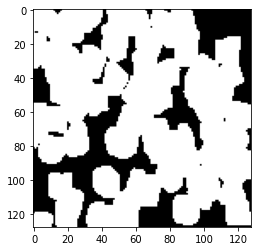

In [44]:
# mostrar la mascara predicha

test_img = preds_test_thresh[3, :, :, 0]

plt.imshow(test_img, cmap='gray')



## Presentación de resultados y uso de métricas


A continuacion se tomaran 3 mascaras de las predichas por la red neuronal, ademas, encontraremos las mascaras correspondientes por el metodo de umbralizacion - otsu para tener una comparacion clara de ambas alternativas.


In [69]:
# se leen las imagenes de el set de prueba de la red neuronal para posteriormente realizar la segmentacion con umbralizacion

# umbralizacion automatica mediante el metodo de otsu
img_id = df_test.loc[0,'image_id']
path_img = os.path.abspath(os.getcwd())+'/content/imagenesPre/' + img_id
test_image = cv2.imread(path_img)

test_image = skimage.color.rgb2gray(test_image)

t = skimage.filters.threshold_otsu(test_image)
print("Found automatic threshold t = {}.".format(t))

# creacion mascara mediante la umbralizacion automatica
binary_mask1 = test_image > t


#------------------------------------------------------------------------------------

# umbralizacion automatica mediante el metodo de otsu
img_id = df_test.loc[1,'image_id']
path_img = os.path.abspath(os.getcwd())+'/content/imagenesPre/' + img_id
test_image = cv2.imread(path_img)

test_image = skimage.color.rgb2gray(test_image)

t = skimage.filters.threshold_otsu(test_image)
print("Found automatic threshold t = {}.".format(t))

# creacion mascara mediante la umbralizacion automatica
binary_mask2 = test_image > t

#-------------------------------------------------------------------------------------

# umbralizacion automatica mediante el metodo de otsu
img_id = df_test.loc[2,'image_id']
path_img = os.path.abspath(os.getcwd())+'/content/imagenesPre/' + img_id
test_image = cv2.imread(path_img)

test_image = skimage.color.rgb2gray(test_image)

t = skimage.filters.threshold_otsu(test_image)
print("Found automatic threshold t = {}.".format(t))

# creacion mascara mediante la umbralizacion automatica
binary_mask3 = test_image > t



Found automatic threshold t = 0.3020220588235294.
Found automatic threshold t = 0.302734375.
Found automatic threshold t = 0.2991727941176471.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


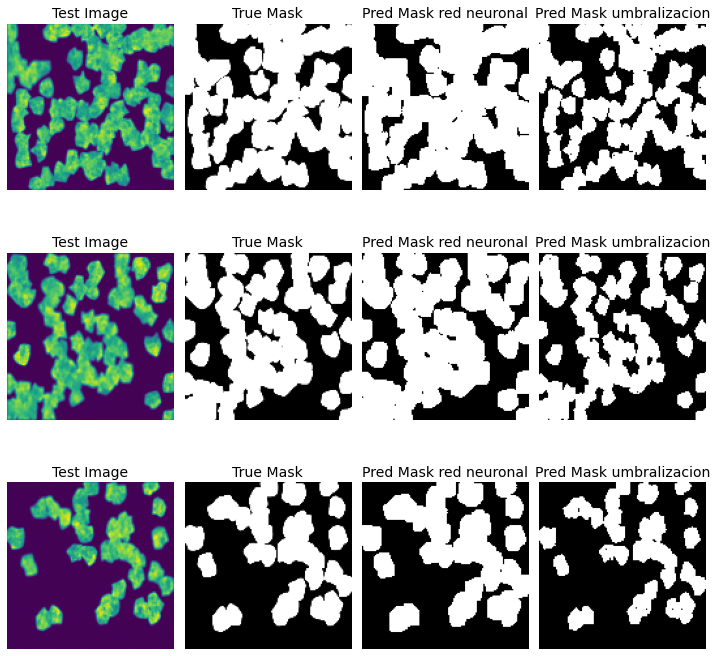

In [71]:
# se crea el lienzo para los subplot
plt.figure(figsize=(10,10))
plt.axis('Off')

#  nuestros subplots contendran 3 filas y 4 columnas
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# imagen
plt.subplot(3,4,1)
test_image = X_test[0, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,4,2)
mask_id = df_test.loc[0,'mask_id']
path_mask = os.path.abspath(os.getcwd())+'/content/mascaras/' + mask_id
mask = cv2.imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# mascara predicha por la red neuronal
plt.subplot(3,4,3)
test_mask = preds_test_thresh[0, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask red neuronal', fontsize=14)
plt.axis('off')

# mascara predicha mediante umbralizacion
plt.subplot(3,4,4)
test_mask = binary_mask1
test_mask= resize(test_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask umbralizacion', fontsize=14)
plt.axis('off')


# == row 2 ===============================================================================================

# imagen
plt.subplot(3,4,5)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,4,6)
mask_id = df_test.loc[1,'mask_id']
path_mask = os.path.abspath(os.getcwd())+'/content/mascaras/' + mask_id
mask = cv2.imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# mascara predicha por la red neuronal
plt.subplot(3,4,7)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask red neuronal', fontsize=14)
plt.axis('off')

# mascara predicha mediante umbralizacion
plt.subplot(3,4,8)
test_mask = binary_mask2
test_mask= resize(test_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask umbralizacion', fontsize=14)
plt.axis('off')


# == row 3 =============================================================================================

# imagen
plt.subplot(3,4,9)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,4,10)
mask_id = df_test.loc[2,'mask_id']
path_mask = os.path.abspath(os.getcwd())+'/content/mascaras/' + mask_id
mask = cv2.imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# mascara predicha por la red neuronal
plt.subplot(3,4,11)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask red neuronal', fontsize=14)
plt.axis('off')

# mascara predicha mediante umbralizacion
plt.subplot(3,4,12)
test_mask = binary_mask3
test_mask= resize(test_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask umbralizacion', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

En este cuadro comparativo se tienen 4 entradas, la primera es la imagen original, la segunda es la mascara que provee el dataset, la tercera es la mascara predicha por red neuronal y por ultimo la mascara predicha por umbralizacion, la metrica a utilizar sera el ajuste a los objetos de la imagen real.

Con base en estas mascaras se puede apreciar de manera clara que la mascara que mas se aproxima a la imagen real es la macara predicha mediante la umbralizacion, se tiene la hipotesis que esto es debido a la naturaleza de las imagenes en si misma, las cuales tienen una diferencia muy clara entre un fondo totalmente negro y los objetos que estan en escala de grises, en algunos casos especificos se puede observar que a raiz de esto se tienen pequeños huecos en algunas celulas, por ejemplo, en la tercera prediccion se observan de manera diminuta algunos vacios donde en la imagen real no se encuentran, esto debido a que el umbral elegido mediante el metodo de otsu esta por debajo de su escala de gris.

Por el lado de la mascara predicha por la red neuronal, se ve que dentro de la misma los objetos tienen una forma mucho mas grande que los de la imagen original, se tiene la hipotesis de que esto se debe principalmente a el desenfoque de las imagenes, el cual confunde a al red en el proceso de identificacion de objetos.

Por ultimo, la mascara que provee el dataset es claramente mejor que la mascara predicha por la red neuronal, aunque en terminos de ajuste es peor a la de la umbralizacion, identificando objetos un poco mas grandes que los vistos en la imagen original.

En conclusion, se tiene un resultado bastante gratificante, ya que mediante el metodo de umbralizacion-otsu logramos generar una mascara con mejor ajuste que la mascara entregada en el dataset.

## Análisis y conclusiones


Se llevo a cabo durante el proyecto un proceso de vision artificial hasta la etapa de segmentacion, para esto utilizamos distintos algoritmos que nos ayudaron a llegar al objetivo. En primer lugar, hicimos una exploracion de las imagenes dentro de nuestro dataset y encontramos que solo 1200 tenian mascar asociada, por esto el dataset se recorta y procedemos a explorar estas imagenes, encontramos que el mejor modelo de color para el proyecto era la escala de grises y que algunas imagenes tenian un grado de desenfoque.

En segundo lugar, procedimos a hacer el pre procesamiento con el objetivo de minimizar el desenfoque con el metodo convolución con el kernel(nucleo) [[0,-1,0],[-1,5,-1],[0,-1,0]], observamos que existia una mejoria pero minima frente a las imagenes originales.

En tercer lugar, se entro a la etapa de segmentacion y se utilizaron 2 metodos: la umbralizacion - otsu y una red neuronal, dentro de la utilizacion de la umbralizacion se encontro una manera simple y efectiva de separar los objetos de su fonde, para una vision mas completa de análisis se implementa una red neutonal con arquitectura U-net, en este proceso se encontraron algunos problemas como el desenfoque de cada imagen y una falta de canal de dimension en las imagenes.

Por ultimo, se compararon los resultados de ambos metodos de segmetacion, dando por resultado final una mascara mejor a la entregada por el dataset obtenida mediante el metodo de umbralizacion-otsu debido presuntamente a la naturaleza de las imagenes, tambien se ve que la mascara predicha por la red neuronal sobreajusta los objetos de la imagen real debido posiblemente al desenfoque de las imagenes.

En conclusion, en el proyecto se identifico mediante las etapas de exploracion con que imagenes trabajar y que algunas tenian un desenfoque, esto siendo el mayor inconveninte de todo el proceso lo cual posteriormente se intento mejorar mediante el pre procesamiento, por otro lado, se tiene una mascara predicha de manera satisfactoria mediante el metodo umbralizacion-otsu y otra mascara predicha de menor calidad mediante la red neuronal, finalizando asi la etapa de segmentacion y el proyecto.